# **ENCODER-DECODER MODEL WITH ATTENTION & WITHOUT ATTENTION FOR TEXT SUMMARIZATION**

*This project focuses on implementing and comparing two approaches for text summarization: an Encoder-Decoder model with attention and another without attention. The attention-based model dynamically focuses on relevant parts of the input text during each decoding step, enhancing summary accuracy, especially for long sequences. In contrast, the model without attention relies solely on fixed context vectors, making it less effective for complex inputs. Both models are trained using tokenized data, evaluated using BLEU scores, and tested to generate summaries from dialogues. The comparison highlights the importance of attention mechanisms in improving text summarization quality.*









## **About The Dataset :**

*The SAMSum Dataset is a collection of dialogues specifically curated for the task of abstractive text summarization. It was created to address the challenge of summarizing conversational data, such as chat messages or casual conversations. Each dialogue is paired with a high-quality human-generated summary.*

## **Implementation Of The Model**

### **1. Importing libraries**

In [1]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 9.4 MB/s eta 0:00:00


In [2]:
pip install pydot

In [3]:
from textblob import Word
# Import the Word class from TextBlob for word-level operations like lemmatization.

import nltk
# Import the NLTK library, which provides tools for processing text data.

nltk.download('wordnet')
# Download the WordNet dataset from NLTK, which is used for lemmatization and other tasks.


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
# Libraray for Data Manipulation
import numpy as np
import pandas as pd

# Libraray for Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white",font_scale=1.5)
sns.set(rc={"axes.facecolor":"#FFFAF0","figure.facecolor":"#FFFAF0"})
sns.set_context("poster",font_scale = .7)

# Library for preprocessing
import contractions
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import spacy
import math
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import Parallel, delayed
import re,string,unicodedata
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from scipy.sparse import lil_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk import pos_tag

# Library for model building
from tensorflow.keras.regularizers import l2
import tensorflow
import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential,Model
#from attention import BahdanauAttention
from keras.layers import SimpleRNN,LSTM,GRU, Embedding, Dense, SpatialDropout1D, Dropout, BatchNormalization, Bidirectional, Attention, Input, Concatenate
from sklearn.metrics import accuracy_score
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import Adam

#Library to overcome Warnings
import warnings
warnings.filterwarnings('ignore')


### **2. Load and Inspect Dataset**




In [6]:
train_df = pd.read_csv('/content/samsum-train.csv')
test_df = pd.read_csv('/content/samsum-test.csv')

In [7]:
train_df.sample(5)

,id,dialogue,summary
661,13611490,"Jerry: Hello. I just wanted to write and ask, ...",Training starts at 6:30. Larry reminds Jerry a...
6524,13816840-1,"Allisson: Jake!\r\nAllisson: I'm so sorry, I'm...",Allison will be late to a meeting with Jake.
3838,13680915,"Lena: Hi, Mike. How are you?\r\nMike: I'm fine...",Lena received Mike's number from Claire. Lena ...
14454,13612025,"Kate: Hello, remember me? From the library?\r\...",Kate collected book that Jill forgot. Kate is ...
2714,13817264,John: Damn it. We lost.\r\nAudrey: u serious? ...,John's team lost the game. Audrey comforts him.


In [8]:
test_df.sample(5)

,id,dialogue,summary
289,13815437,Caroline: I think his mother doesn't like me.....,Kate believes her boyfriend's mother dislikes ...
704,13862650,Suzy: don't forget to follow me on Instagram :...,Suzy urges Linda to follow her on Instagram an...
40,13728229,Sebastian: It's been already a year since we m...,"Sebastian is very happy with his life, and sha..."
518,13863131,Lena: that new professor is the worst!\nLena: ...,Lena and Brian don't like their new professor....
435,13680993,Adelina: Hi handsome. Where you you come from?...,Cyprien irritates Adelina by giving too many r...



### **3. Data Exploration**




#### **3.1. Computing Dimension of Dataset**

In [9]:
print("train_df shape: ",train_df.shape)
print("test_df shape: ",test_df.shape)

train_df shape:  (14732, 3)
test_df shape:  (819, 3)


#### **3.2. Statistical Summary of Dataset**

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14732 entries, 0 to 14731
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        14732 non-null  object
 1   dialogue  14731 non-null  object
 2   summary   14732 non-null  object
dtypes: object(3)
memory usage: 345.4+ KB


#### **3.3. Checking if There's Any Duplicate Records.**

In [11]:
print("Duplicates in Dataset: ",train_df.duplicated().sum())

Duplicates in Dataset:  0


#### **3.4. Computing Total No. of Missing Values and the Percentage of Missing Values**

In [12]:
missing_data = train_df.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})
missing_data["% of Missing Values"] = round((missing_data["Total No. of Missing Values"]/len(train_df))*100,2)
missing_data

,Total No. of Missing Values,% of Missing Values
id,0,0.00
dialogue,1,0.01
summary,0,0.00


#### **3.5. Performing Descriptive Analysis**

In [13]:
round(train_df.describe().T,2)

,count,unique,top,freq
id,14732,14732,13729017,1
dialogue,14731,14264,"Jimmy: Hey, guess what? My car's completely ka...",4
summary,14732,14730,Seth's pet Oreo that he got when he was 10 is ...,2


###**4. Preprocessing**



#### **4.1 Dropping unwanted column**

In [14]:
col = 'id'
train_df.drop(col,axis = 1,inplace = True)
test_df.drop(col,axis = 1,inplace = True)

####**4.2 Dropping Duplicates and Null Values**

In [15]:
train_df.dropna(inplace = True)

####**4.3 Lowercasing**

In [16]:
train_df['dialogue'] = train_df['dialogue'].str.lower()
train_df['summary'] = train_df['summary'].str.lower()
test_df['dialogue'] = test_df['dialogue'].str.lower()
test_df['summary'] = test_df['summary'].str.lower()

#### **4.4 Removing Html tags**

In [17]:
import re
def remove_html_tags(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)
    return text


In [18]:
train_df['dialogue'] = train_df['dialogue'].apply(remove_html_tags)
train_df['summary'] = train_df['summary'].apply(remove_html_tags)
test_df['dialogue'] = test_df['dialogue'].apply(remove_html_tags)
test_df['summary'] = test_df['summary'].apply(remove_html_tags)

#### **4.5  Removing URLs**

In [19]:
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'',text)

train_df['dialogue'] = train_df['dialogue'].apply(remove_url)
train_df['summary'] = train_df['summary'].apply(remove_url)
test_df['dialogue'] = test_df['dialogue'].apply(remove_url)
test_df['summary'] = test_df['summary'].apply(remove_url)

####**4.6 Chat word treatment**

In [20]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laughter",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "LOL": "Laughing out loud",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don’t care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "IDC": "I don’t care",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "LMAO": "Laughing my a** off",
    "BFF": "Best friends forever",
    "CSL": "Can’t stop laughing",
}

In [21]:
def chat_conversion(text):
    new_text = []  # Initialize an empty list to store the converted words.

    # Loop through each word in the input text
    for w in text.split():
        if w.upper() in chat_words:  # Check if the uppercase version of the word exists in the 'chat_words' dictionary
            new_text.append(chat_words[w.upper()])  # Replace the word with its corresponding value from 'chat_words'
        else:
            new_text.append(w)  # If no replacement is found, append the word as is.

    return " ".join(new_text)  # Return the processed text as a string with words joined by spaces.


In [22]:
train_df['dialogue'] = train_df['dialogue'].apply(chat_conversion)
train_df['summary'] = train_df['summary'].apply(chat_conversion)
test_df['dialogue'] = test_df['dialogue'].apply(chat_conversion)
test_df['summary'] = test_df['summary'].apply(chat_conversion)

#### **4.7 Removing Emojis**

In [23]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [24]:
train_df['dialogue'] = train_df['dialogue'].apply(remove_emoji)
train_df['summary'] = train_df['summary'].apply(remove_emoji)
test_df['dialogue'] = test_df['dialogue'].apply(remove_emoji)
test_df['summary'] = test_df['summary'].apply(remove_emoji)

#### **4.8 Removing contraction**

In [25]:
def expand_contractions(text):
    expanded_text = contractions.fix(text)  # Use the 'contractions' library to expand contractions in the text
    return expanded_text  # Return the expanded text


train_df['dialogue'] = train_df['dialogue'].apply(expand_contractions)
train_df['summary'] = train_df['summary'].apply(expand_contractions)
test_df['dialogue'] = test_df['dialogue'].apply(expand_contractions)
test_df['summary'] = test_df['summary'].apply(expand_contractions)

In [26]:
train_df['summary'] = ['<start> ' + sentence + ' <end>' for sentence in train_df['summary']]
test_df['summary'] = ['<start> ' + sentence + ' <end>' for sentence in test_df['summary']]

#### **4.9 Tokenize on the Data**

In [27]:
tok = Tokenizer()
tok.fit_on_texts(train_df['dialogue']+train_df['summary'])

In [28]:
len(tok.word_index)

33259

In [29]:
tok.document_count

14731

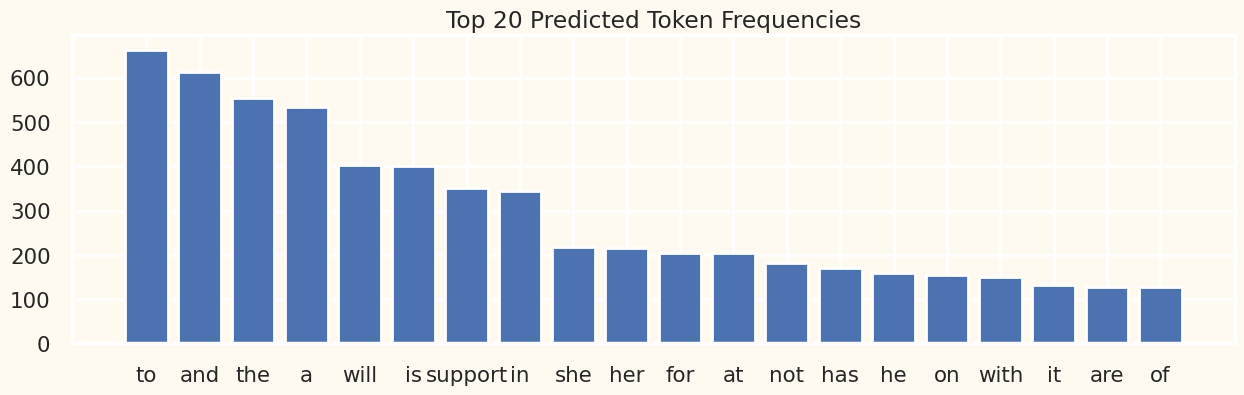

In [85]:
from collections import Counter

# Token distribution for predicted summaries
predicted_tokens = ' '.join(predicted_summaries).split()
predicted_token_counts = Counter(predicted_tokens)

# Token distribution for actual summaries
actual_tokens = ' '.join(actual_summaries).split()
actual_token_counts = Counter(actual_tokens)

# Plot distributions
plt.figure(figsize=(15, 4))

plt.bar(*zip(*predicted_token_counts.most_common(20)))
plt.title('Top 20 Predicted Token Frequencies')

plt.show()

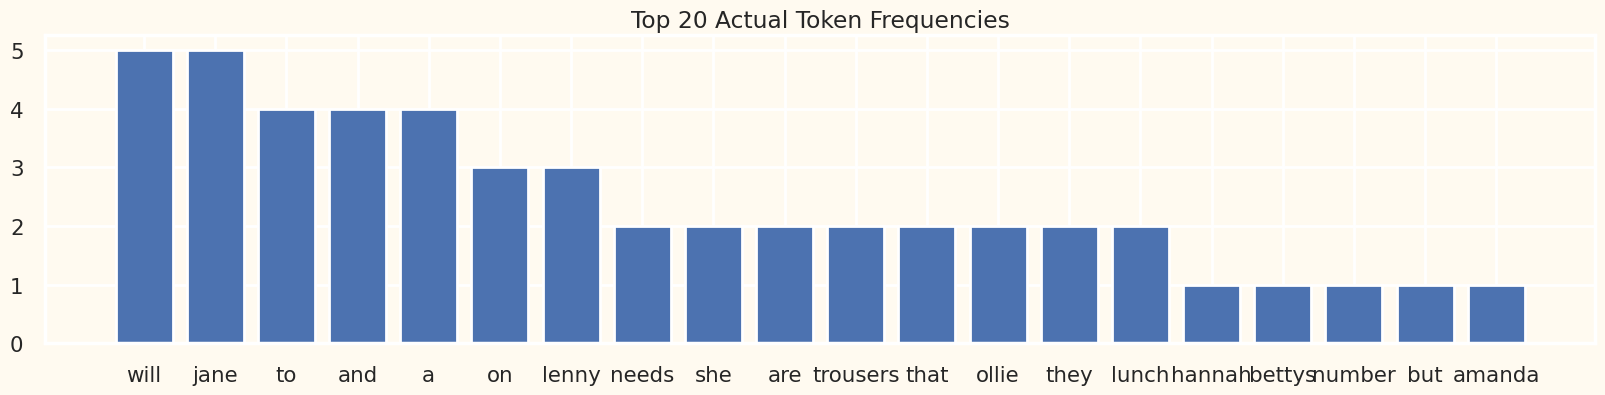

In [86]:

plt.figure(figsize=(20, 4))
plt.bar(*zip(*actual_token_counts.most_common(20)))
plt.title('Top 20 Actual Token Frequencies')
plt.show()

#### **4.10 Converting data in numerical forms**

In [30]:
# Convert training dialogues and summaries to sequences
train_df['dialogue'] = tok.texts_to_sequences(train_df['dialogue'])
train_df['summary'] = tok.texts_to_sequences(train_df['summary'])

# Convert test dialogues and summaries to sequences (without fitting)
test_df['dialogue'] = tok.texts_to_sequences(test_df['dialogue'])
test_df['summary'] = tok.texts_to_sequences(test_df['summary'])

In [31]:
train_df

,dialogue,summary
0,"[423, 1, 3359, 1528, 15, 2, 71, 52, 584, 70, 4...","[16, 423, 3359, 1528, 6, 12, 211, 584, 52, 98,..."
1,"[318, 144, 18, 2, 5396, 11, 10, 39, 2944, 604,...","[16, 318, 6, 1588, 18, 5396, 11, 11934, 10, 39..."
2,"[225, 116, 26, 7, 60, 356, 217, 1440, 3, 24, 8...","[16, 356, 235, 174, 4, 16211, 13671, 1959, 118..."
3,"[1001, 410, 1, 61, 1, 21, 10, 21537, 29, 831, ...","[16, 1001, 556, 38, 7, 10, 132, 29, 831, 410, ..."
4,"[192, 113, 9658, 491, 167, 109, 192, 1, 15, 8,...","[16, 192, 7, 2350, 110, 38, 9658, 491, 2300, 3..."
...,...,...
14727,"[4686, 2, 18, 25, 20, 141, 2, 235, 32, 845, 13...","[16, 4686, 7, 512, 3, 64, 1386, 3, 1281, 76, 3..."
14728,"[1076, 137, 1076, 137, 1076, 113, 882, 50, 18,...","[16, 1076, 7, 27, 96, 33, 765, 323, 341, 6, 32..."
14729,"[112, 432, 146, 52, 217, 527, 2850, 12, 5972, ...","[16, 2850, 7, 46, 3, 5972, 8896, 177, 1983, 6,..."
14730,"[597, 631, 2969, 50, 18, 2, 214, 597, 4, 656, ...","[16, 2969, 101, 8, 129, 9, 3, 4, 656, 29, 4, 3..."


In [32]:
def calculate_max_sequence_length(train_summary, train_dialogue, test_summary, test_dialogue):
    # Find the maximum sequence length in the train_dialogue and train_summary
    max_length_1 = max(max(len(seq) for seq in train_dialogue), max(len(seq) for seq in train_summary))

    # Find the maximum sequence length in the test_dialogue and test_summary
    max_length_2 = max(max(len(seq) for seq in test_dialogue), max(len(seq) for seq in test_summary))

    # Combine the maximum lengths from both train and test datasets
    max_length_combined = max(max_length_1, max_length_2)

    # Return the overall maximum sequence length
    return max_length_combined

# Call the function to calculate the maximum sequence length from both the train and test datasets
max_length_combined = calculate_max_sequence_length(
    train_df['dialogue'],
    train_df['summary'],
    test_df['dialogue'],
    test_df['summary']
)

# Output the combined maximum sequence length
max_length_combined


819

In [33]:
# Iterate over each character in the first dialogue entry of the train_df and print them
for num in train_df['dialogue'][0]:
    print(num, end=' ')  # 'end=' ensures that characters are printed on the same line with a space


423 1 3359 1528 15 2 71 52 584 70 423 54 211 2 98 

In [34]:
# Print corresponding words horizontally
for num in train_df['dialogue'][0]:
    word = tok.index_word.get(num, 'UNK')
    print(word, end=' ')

amanda i baked cookies do you want some jerry sure amanda ill bring you tomorrow 

In [35]:
for num in train_df['summary'][0]:
    word = tok.index_word.get(num)
    print(word,end = " ")

start amanda baked cookies and will bring jerry some tomorrow end 

#### **4.11 separating the data in dependent and independent and padding it**

In [36]:
x_train = pad_sequences(train_df['dialogue'],maxlen = max_length_combined,padding = 'post')
y_train = pad_sequences(train_df['summary'],maxlen = max_length_combined,padding = 'post')
x_test = pad_sequences(test_df['dialogue'],maxlen = max_length_combined,padding = 'post')
y_test = pad_sequences(test_df['summary'],maxlen = max_length_combined,padding = 'post')

In [37]:
x_train

array([[ 423,    1, 3359, ...,    0,    0,    0],
       [ 318,  144,   18, ...,    0,    0,    0],
       [ 225,  116,   26, ...,    0,    0,    0],
       ...,
       [ 112,  432,  146, ...,    0,    0,    0],
       [ 597,  631, 2969, ...,    0,    0,    0],
       [1586,   18,    2, ...,    0,    0,    0]], dtype=int32)

In [38]:
y_train

array([[  16,  423, 3359, ...,    0,    0,    0],
       [  16,  318,    6, ...,    0,    0,    0],
       [  16,  356,  235, ...,    0,    0,    0],
       ...,
       [  16, 2850,    7, ...,    0,    0,    0],
       [  16, 2969,  101, ...,    0,    0,    0],
       [  16, 1586,    6, ...,    0,    0,    0]], dtype=int32)

In [39]:
# Check the shape of the resulting arrays
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (14731, 819)
Shape of x_test: (819, 819)
Shape of y_train: (14731, 819)
Shape of y_test: (819, 819)


## **5.1. Encoder-Decoder Model Without Attention**

###**Define Encoder-Decoder Model**

In [40]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import os
from nltk.translate.bleu_score import corpus_bleu

# Set parameters
max_length_input = x_train.shape[1]
max_length_output = y_train.shape[1]
input_vocab_size = len(tok.word_index) + 1
output_vocab_size = len(tok.word_index) + 1

# Define Encoder model
encoder_inputs = Input(shape=(max_length_input,))
encoder_embedding = Embedding(input_dim=input_vocab_size, output_dim=260)(encoder_inputs)
encoder_lstm = LSTM(64, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Define Decoder model
decoder_inputs = Input(shape=(max_length_output,))
decoder_embedding = Embedding(input_dim=output_vocab_size, output_dim=260)(decoder_inputs)
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Dense Layer for output prediction (no attention here)
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the full Encoder-Decoder model
model_no_attention = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model_no_attention.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_no_attention.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 819)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 819)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 819, 260)       │      8,647,600 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 819, 260)       │      8,647,600 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 64), (None,    │         83,200 │ embedding[0][0]        │
│                           │ 64), (None, 64)]       │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 819, 64),      │         83,200 │ embedding_1[0][0],     │
│                           │ (None, 64), (None,     │                │ lstm[0][1], lstm[0][2] │
│                           │ 64)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 819, 33260)     │      2,161,900 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 19,623,500 (74.86 MB)

 Trainable params: 19,623,500 (74.86 MB)

 Non-trainable params: 0 (0.00 B)

### **Visualize the model**

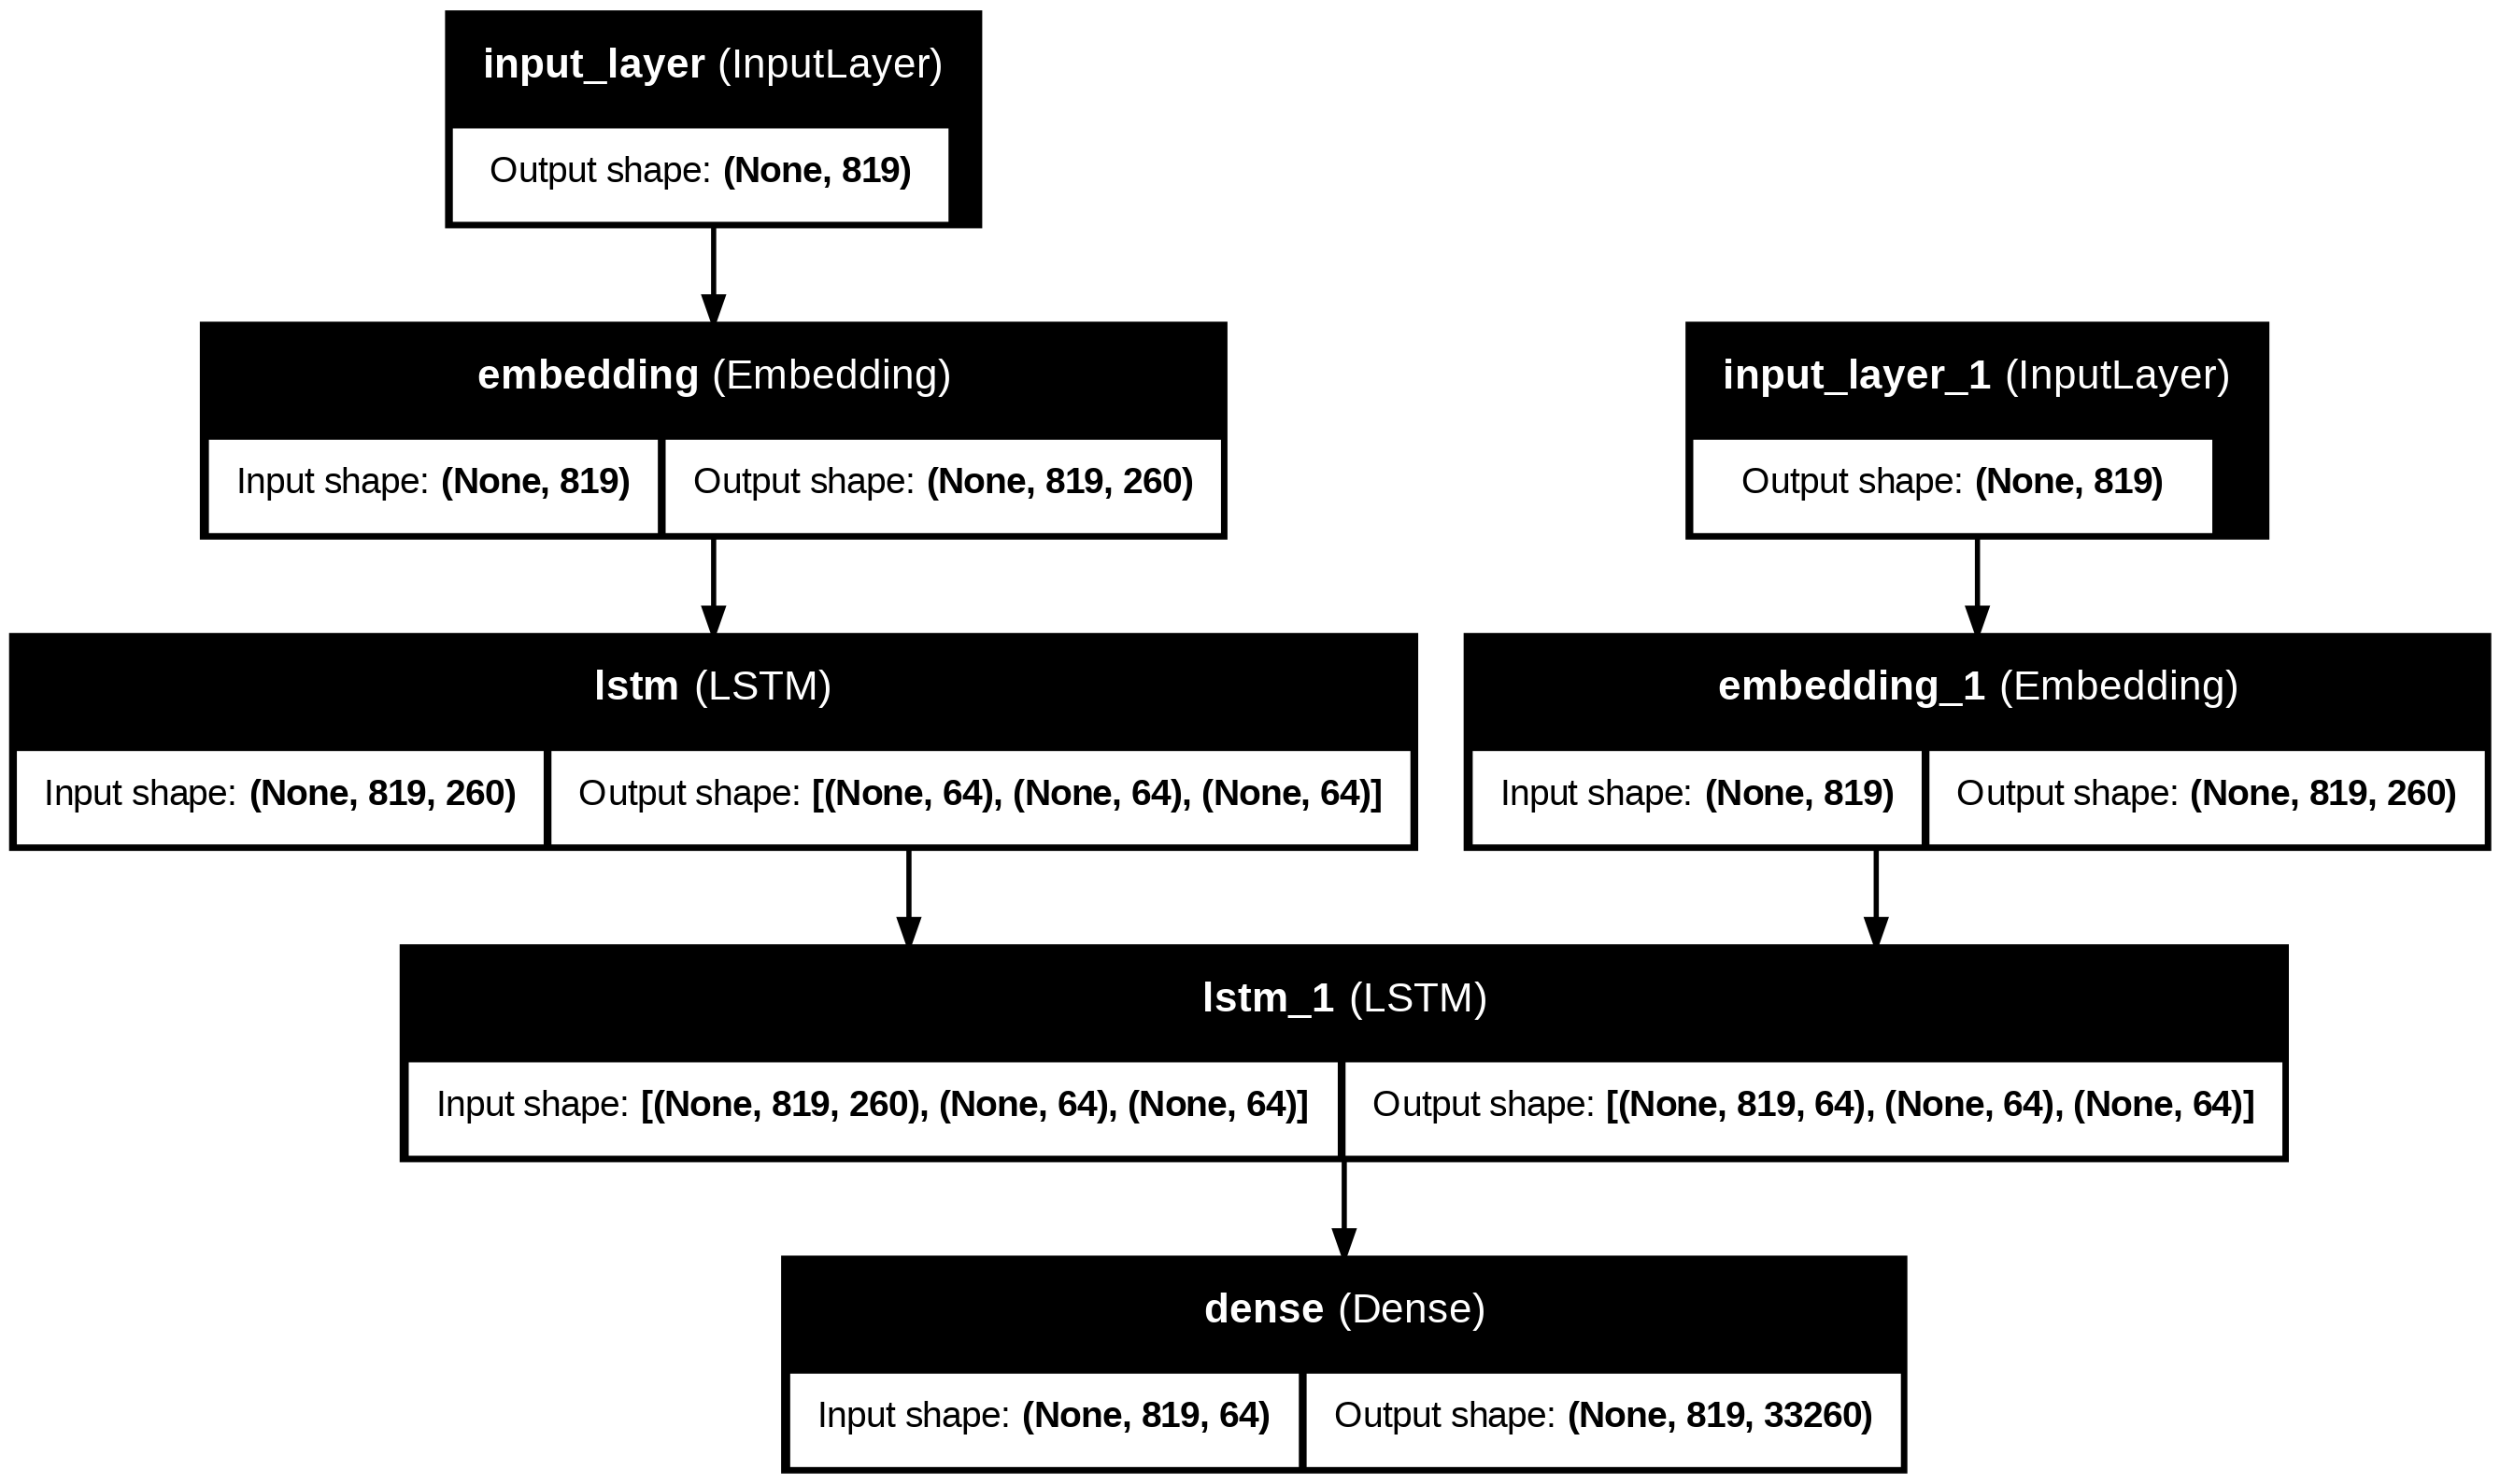

In [41]:

from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model_no_attention, to_file='model_no_attention_plot.png', show_shapes=True, show_layer_names=True)
Image('model_no_attention_plot.png')

### **Train the model**

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model_no_attention_checkpoint.keras', save_best_only=True)

# Train the model with callbacks
history_no_attention = model_no_attention.fit(
    x=[x_train, y_train],
    y=y_train,
    batch_size=16,
    epochs=5,
    validation_data=([x_test, y_test], y_test),
    callbacks=[early_stopping, model_checkpoint],
)

# Plot training and validation loss/accuracy
epochs_range = range(1, len(history_no_attention.history['loss']) + 1)




Epoch 1/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 302s 322ms/step - accuracy: 0.9656 - loss: 1.9896 - val_accuracy: 0.9820 - val_loss: 0.1423
Epoch 2/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 322s 326ms/step - accuracy: 0.9830 - loss: 0.1376 - val_accuracy: 0.9866 - val_loss: 0.1071
Epoch 3/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 300s 326ms/step - accuracy: 0.9870 - loss: 0.1058 - val_accuracy: 0.9902 - val_loss: 0.0829
Epoch 4/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 322s 326ms/step - accuracy: 0.9903 - loss: 0.0830 - val_accuracy: 0.9927 - val_loss: 0.0648
Epoch 5/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 300s 325ms/step - accuracy: 0.9927 - loss: 0.0652 - val_accuracy: 0.9941 - val_loss: 0.0524


### **Plot Loss**

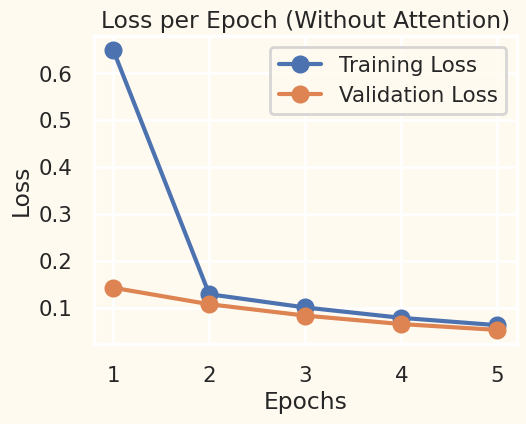

In [43]:
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_no_attention.history['loss'], label='Training Loss', marker='o')
plt.plot(epochs_range, history_no_attention.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss per Epoch (Without Attention)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs_range)
plt.legend()

plt.show()

### **Plot Accuracy**

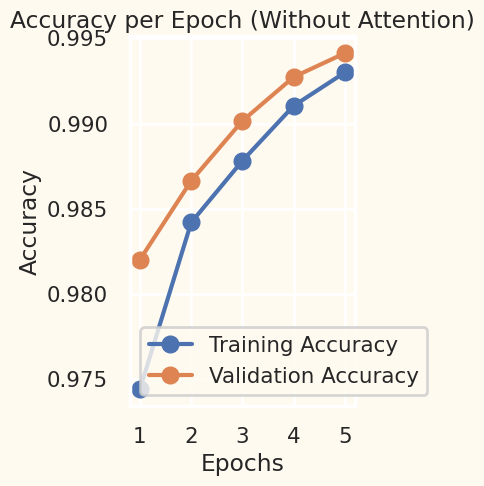

In [44]:

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_no_attention.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs_range, history_no_attention.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch (Without Attention)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs_range)
plt.legend()

plt.show()

### **Prediction From the Model**

In [46]:
# Reverse token dictionaries for dialogue and summary
rev_tok_summary = {idx: word for word, idx in tok.word_index.items()}
rev_tok_dialogue = {idx: word for word, idx in tok.word_index.items()}  # If using the same tokenizer for dialogues

# Define the batch size
batch_size = 10

# Initialize lists to store predictions, references, and dialogues
predicted_summaries = []
references = []
english_sentences = []  # To store dialogues for printing
actual_summaries = []  # To store actual summaries for printing

# Predict on x_test data in batches
for start in range(0, len(x_test), batch_size):
    end = min(start + batch_size, len(x_test))
    x_batch = x_test[start:end]
    y_batch = y_test[start:end]

    # Predict on the batch
    predictions = model_no_attention.predict([x_batch, y_batch], batch_size=batch_size)

    # Convert predicted tokens to sentences (predicted summaries)
    predicted_tokens_np = np.argmax(predictions, axis=-1)

    for sample in predicted_tokens_np:
        predicted_sentence = ' '.join([rev_tok_summary.get(token, '<unknown>') for token in sample if token != 0])
        predicted_summaries.append(predicted_sentence)

    # Extract the true (actual) summaries for BLEU score references and printing
    for i in range(len(y_batch)):
        true_summary_sentence = ' '.join([rev_tok_summary.get(token, '<unknown>') for token in y_batch[i] if token != 0])
        references.append([true_summary_sentence.split()])
        actual_summaries.append(true_summary_sentence)  # Store for printing

    # Extract the dialogues for printing
    for sample in x_batch:
        dialogue_sentence = ' '.join([rev_tok_dialogue.get(token, '<unknown>') for token in sample if token != 0])
        english_sentences.append(dialogue_sentence)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

In [47]:
 #Print the dialogue, predicted summary, and actual summary
for idx, (eng_sentence, pred_summary, actual_summary) in enumerate(zip(english_sentences, predicted_summaries, actual_summaries)):
    print(f"Dialogue {idx + 1}: {eng_sentence}")
    print(f"Predicted summary {idx + 1}: {pred_summary}")
    print(f"Actual summary {idx + 1}: {actual_summary}\n")


Dialogue 1: hannah hey do you have bettys number amanda let me check hannah filegif amanda sorry cannot find it amanda ask larry amanda he called her last tears in my eyes we were at the park together hannah i do not know him well hannah filegif amanda do not be shy hes very nice hannah if you say so hannah id rather you texted him amanda just text him hannah urgh alright hannah bye amanda bye bye
Predicted summary 1: start hannah needs number but amanda does not have it she needs to attend end
Actual summary 1: start hannah needs bettys number but amanda does not have it she needs to contact larry end

Dialogue 2: eric machine rob that is so great eric i know and shows how americans see russian rob and its really funny eric i know i especially like the train part rob hahaha no one talks to the machine like that eric is this his only standup rob i do not know ill check eric sure rob turns out no there are some of his standups on youtube eric great ill watch them now rob me too eric mac

### **Evaluate BLEU score**

In [48]:
# Evaluate BLEU score
bleu_score = corpus_bleu(references, [pred.split() for pred in predicted_summaries])
print(f'BLEU score (No Attention): {bleu_score:.4f}\n')
#


BLEU score (No Attention): 0.5191



### **Save the entire model**

In [49]:
# Save the entire model
model_no_attention.save('encoder_decoder_model_no_attention.h5')
print('Model without attention saved successfully!')


Model without attention saved successfully!


##**Encoder-Decoder Model With Attention**

In [52]:
max_length_input = x_train.shape[1]
max_length_output = y_train.shape[1]
input_vocab_size = len(tok.word_index) + 1
output_vocab_size = len(tok.word_index) + 1

# Define Encoder model
encoder_inputs = Input(shape=(max_length_input,))
encoder_embedding = Embedding(input_dim=input_vocab_size, output_dim=260)(encoder_inputs)
encoder_lstm = LSTM(64, return_sequences=True, return_state=True)  # Ensure return_sequences=True
encoder_lstm = LSTM(64, return_sequences=True, return_state=True)  # Ensure return_sequences=True
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Define Decoder model
decoder_inputs = Input(shape=(max_length_output,))
decoder_embedding = Embedding(input_dim=output_vocab_size, output_dim=260)(decoder_inputs)
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention Layer
attention = Attention()([decoder_outputs, encoder_outputs])

# Concatenate attention output with decoder outputs
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention])

# Dense Layer for output prediction
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the full Encoder-Decoder model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 819)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 819)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 819, 260)       │      8,647,600 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 819, 260)       │      8,647,600 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, 819, 64),      │         83,200 │ embedding_2[0][0]      │
│                           │ (None, 64), (None,     │                │                        │
│                           │ 64)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ [(None, 819, 64),      │         83,200 │ embedding_3[0][0],     │
│                           │ (None, 64), (None,     │                │ lstm_3[0][1],          │
│                           │ 64)]                   │                │ lstm_3[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 819, 64)        │              0 │ lstm_5[0][0],          │
│                           │                        │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 819, 128)       │              0 │ lstm_5[0][0],          │
│                           │                        │                │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 819, 33260)     │      4,290,540 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 21,752,140 (82.98 MB)

 Trainable params: 21,752,140 (82.98 MB)

 Non-trainable params: 0 (0.00 B)

### **Visualize the model**

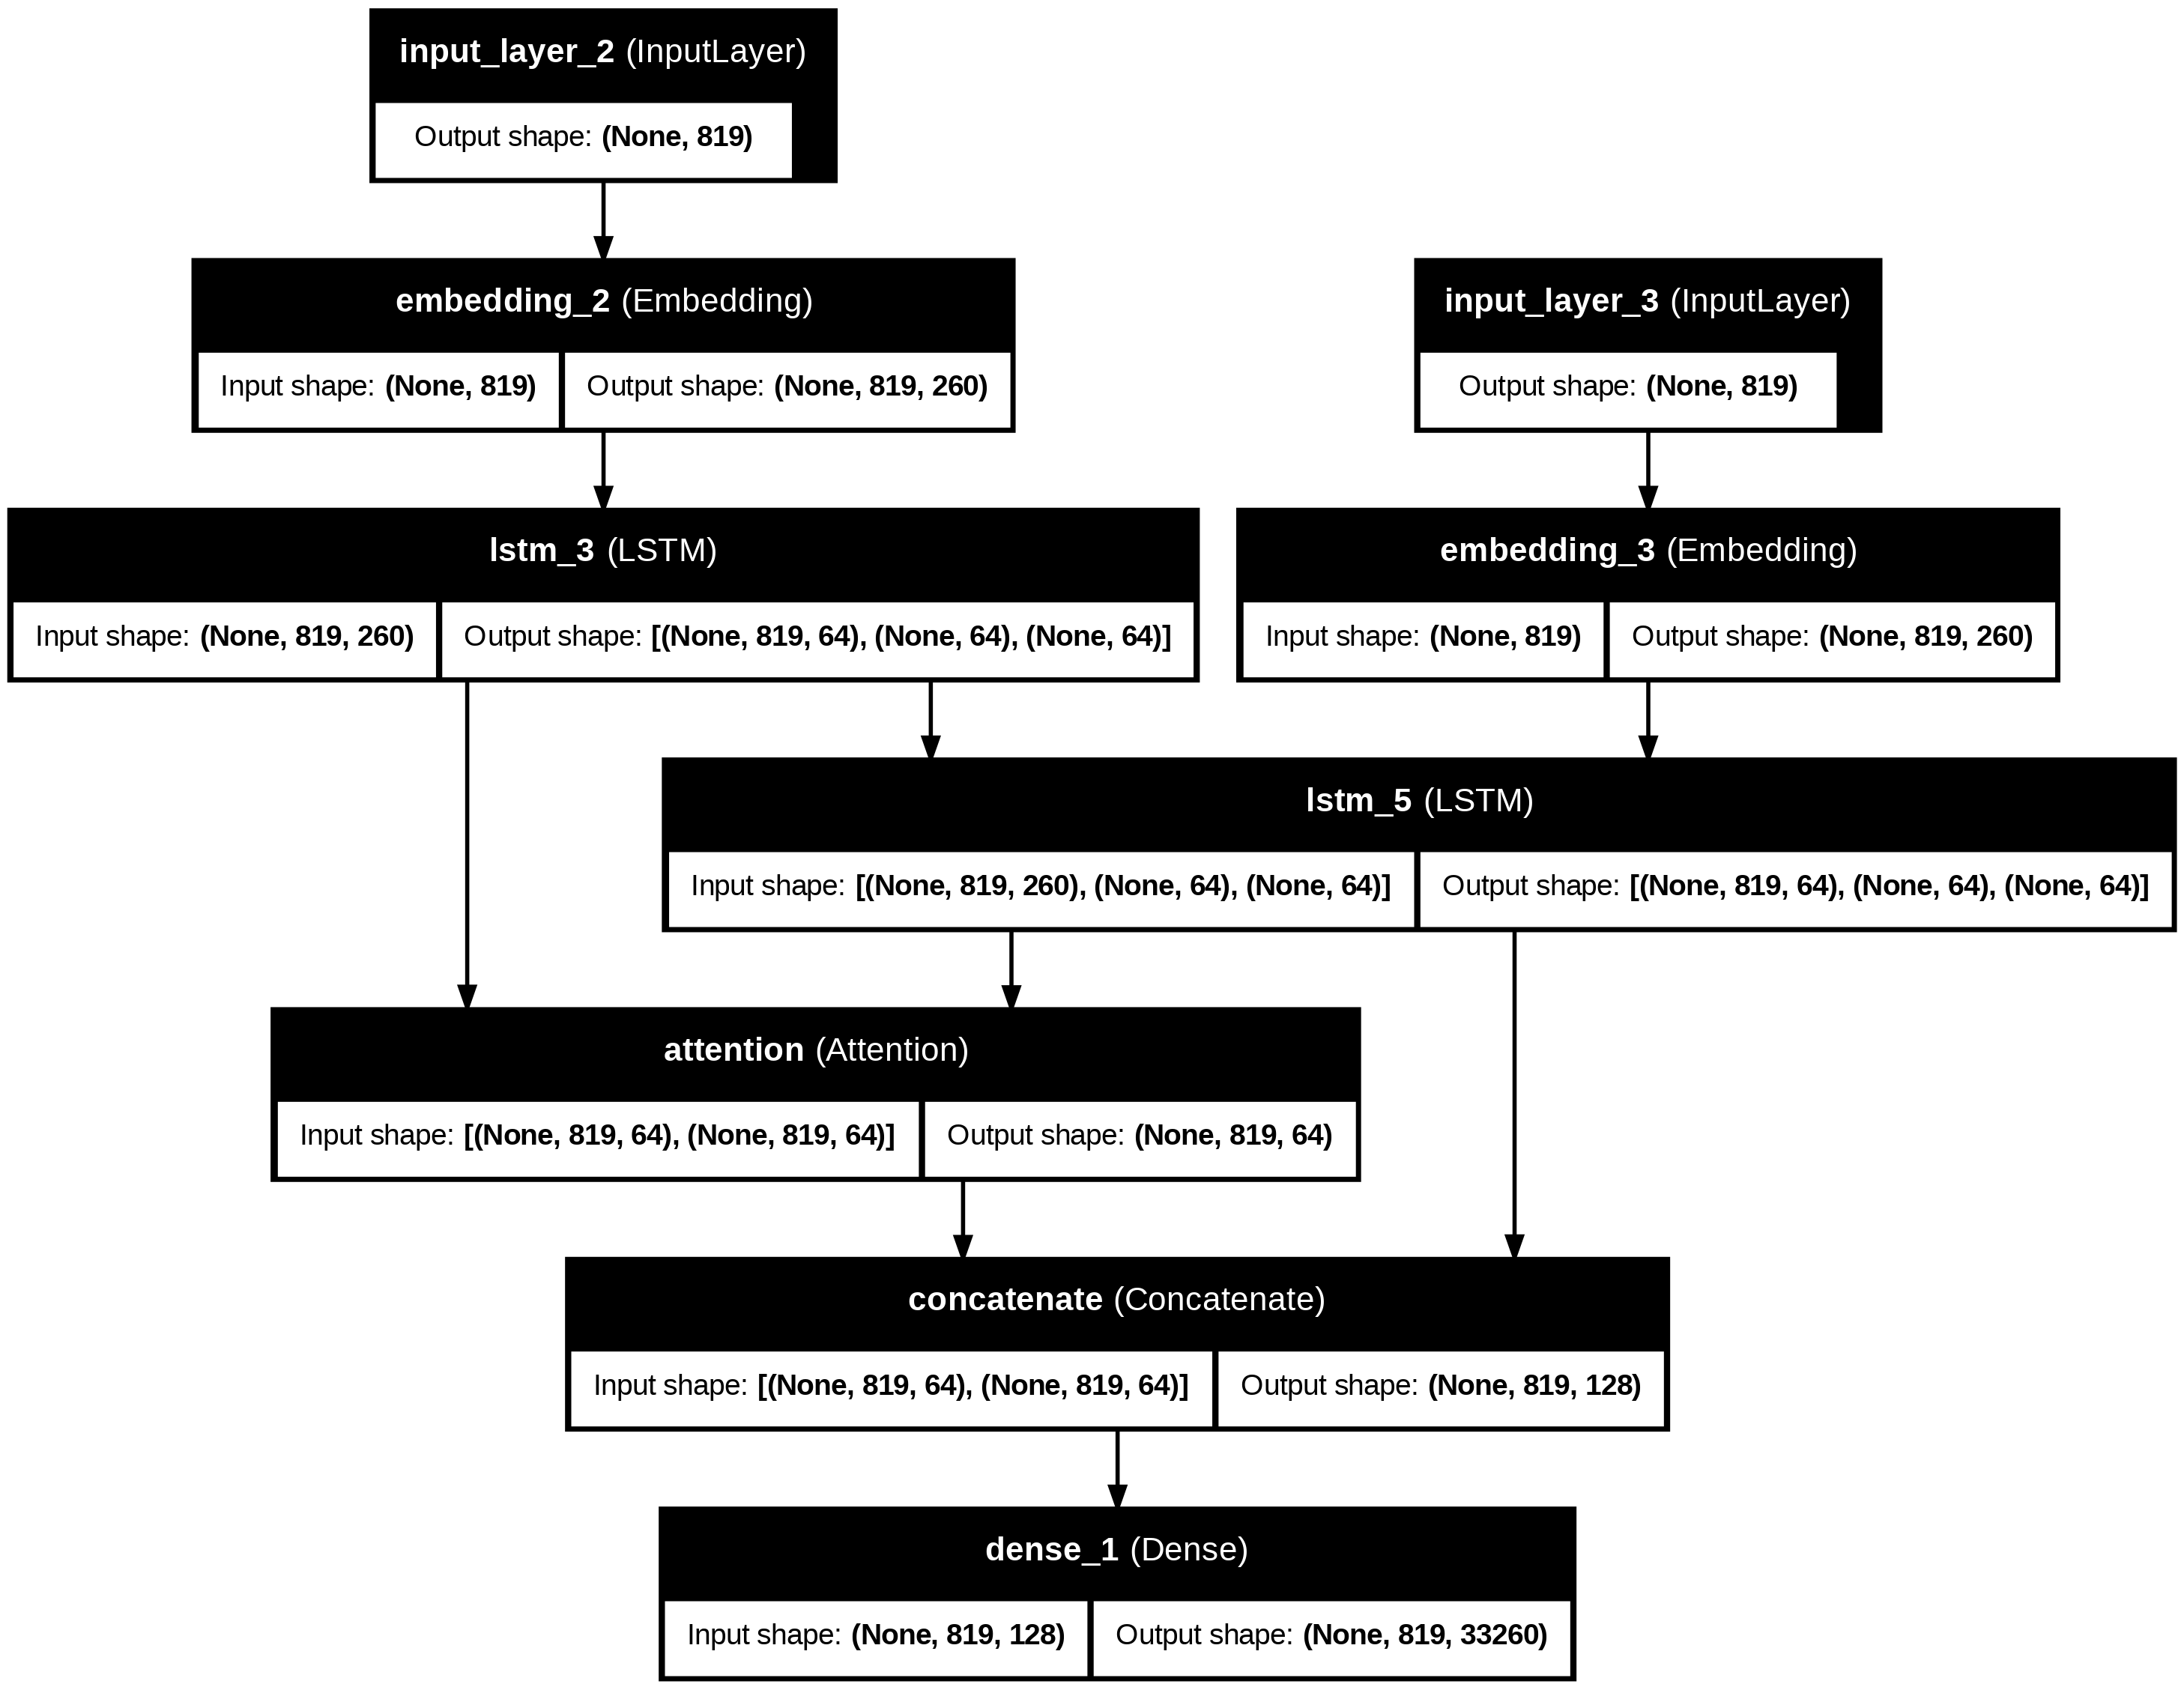

In [53]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
Image('model_plot.png')


### **Train the model**

In [54]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model_checkpoint.keras', save_best_only=True)  # Updated filepath

# Train the model with callbacks
history = model.fit(
    x=[x_train, y_train],
    y=y_train,
    batch_size=16,
    epochs=5,
    validation_data=([x_test, y_test], y_test),
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 345s 372ms/step - accuracy: 0.9675 - loss: 1.2699 - val_accuracy: 0.9848 - val_loss: 0.1205
Epoch 2/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 385s 376ms/step - accuracy: 0.9858 - loss: 0.1155 - val_accuracy: 0.9904 - val_loss: 0.0805
Epoch 3/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 391s 386ms/step - accuracy: 0.9905 - loss: 0.0787 - val_accuracy: 0.9931 - val_loss: 0.0585
Epoch 4/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 354s 385ms/step - accuracy: 0.9931 - loss: 0.0590 - val_accuracy: 0.9949 - val_loss: 0.0450
Epoch 5/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 352s 383ms/step - accuracy: 0.9948 - loss: 0.0456 - val_accuracy: 0.9959 - val_loss: 0.0357


### **Plot Loss**

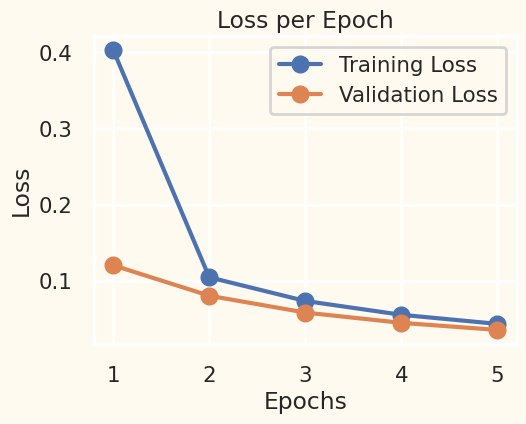

In [55]:
epochs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['loss'], label='Training Loss', marker='o')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs_range)
plt.legend()

plt.show()

### **Plot Accuracy**

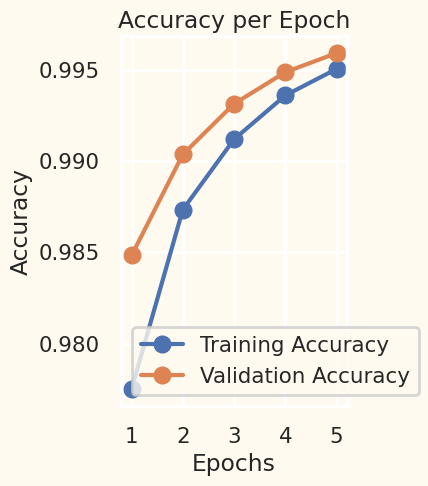

In [56]:
# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs_range)
plt.legend()


plt.show()

### **Prediction from the Model**

In [57]:
from nltk.translate.bleu_score import corpus_bleu

# Reverse token dictionary for summary (assuming you have a tokenizer `tok` for summary)
rev_tok_summary = {idx: word for word, idx in tok.word_index.items()}
rev_tok_dialogue = {idx: word for word, idx in tok.word_index.items()}  # If the dialogue uses the same tokenizer

# Define the batch size
batch_size = 10

# Initialize lists to store predictions and references
predicted_summaries = []
references = []

# Predict on x_test data in batches
for start in range(0, len(x_test), batch_size):
    end = min(start + batch_size, len(x_test))
    x_batch = x_test[start:end]
    y_batch = y_test[start:end]  # Use the corresponding y_test for padding purposes

    # Predict on the batch
    predictions = model.predict([x_batch, y_batch], batch_size=batch_size)

    # Convert predicted tokens to sentences (predicted summaries)
    predicted_tokens_np = np.argmax(predictions, axis=-1)

    for sample in predicted_tokens_np:
        # Convert the predicted tokens into the corresponding words for the summary
        predicted_sentence = ' '.join([rev_tok_summary.get(token, '<unknown>') for token in sample if token != 0 and token not in [tok.word_index.get('start'), tok.word_index.get('end')]])
        predicted_summaries.append(predicted_sentence)

    # Extract the true (actual) summaries for the BLEU score references
    for i in range(len(y_batch)):
        true_summary_sentence = ' '.join([rev_tok_summary.get(token, '<unknown>') for token in y_batch[i] if token != 0 and token not in [tok.word_index.get('start'), tok.word_index.get('end')]])
        references.append([true_summary_sentence.split()])  # BLEU expects list of references for each hypothesis

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

### **Evaluate BLEU score**

In [58]:
# Evaluate BLEU score for the predicted summaries
bleu_score = corpus_bleu(references, [pred.split() for pred in predicted_summaries])
print(f'BLEU score: {bleu_score:.4f}')

BLEU score: 0.6495


In [59]:
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Reverse token dictionaries
rev_tok = {idx: word for word, idx in tok.word_index.items()}

# Select a subset of test data
num_samples = 5
x_test_subset = x_test[:num_samples]
y_test_padded_subset = y_test[:num_samples]

# Predict
predictions = model.predict([x_test_subset, y_test_padded_subset], batch_size=16)
print('Shape of predictions:', predictions.shape)

# Convert predictions to token indices
predicted_tokens_np = np.argmax(predictions, axis=-1)
print('Shape of predicted_tokens:', predicted_tokens_np.shape)

# Map indices to tokens and remove 'start' and 'end' tokens from predicted summary
predicted_sentences = []
for sample in predicted_tokens_np:
    sentence = ' '.join([rev_tok.get(token, '<unknown>') for token in sample if token != 0 and token not in [tok.word_index.get('start'), tok.word_index.get('end')]])  # Exclude padding, 'start', and 'end' tokens
    predicted_sentences.append(sentence)

# Reverse token dictionary for the dialogue (assuming you have `tok_english` for dialogue tokens)
rev_tok_english = {idx: word for word, idx in tok.word_index.items()}

# Map the dialogue input to sentences
english_sentences = []
for sample in x_test_subset:
    sentence = ' '.join([rev_tok_english.get(token, '<unknown>') for token in sample if token != 0])  # Exclude padding token
    english_sentences.append(sentence)

# Map actual summaries from y_test to sentences
actual_summaries = []
for sample in y_test_padded_subset:
    sentence = ' '.join([rev_tok.get(token, '<unknown>') for token in sample if token != 0 and token not in [tok.word_index.get('start'), tok.word_index.get('end')]])  # Exclude padding, 'start', and 'end' tokens
    actual_summaries.append(sentence)

# Print the dialogue, predicted summary, and actual summary
for idx, (eng_sentence, pred_summary, actual_summary) in enumerate(zip(english_sentences, predicted_sentences, actual_summaries)):
    print(f'Dialogue {idx + 1}: {eng_sentence}')
    print(f'Predicted summary {idx + 1}: {pred_summary}')
    print(f'Actual summary {idx + 1}: {actual_summary}\n')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Shape of predictions: (5, 819, 33260)
Shape of predicted_tokens: (5, 819)
Dialogue 1: hannah hey do you have bettys number amanda let me check hannah filegif amanda sorry cannot find it amanda ask larry amanda he called her last tears in my eyes we were at the park together hannah i do not know him well hannah filegif amanda do not be shy hes very nice hannah if you say so hannah id rather you texted him amanda just text him hannah urgh alright hannah bye amanda bye bye
Predicted summary 1: hannah needs amazon number but amanda does not have it she needs to contact larry
Actual summary 1: hannah needs bettys number but amanda does not have it she needs to contact larry

Dialogue 2: eric machine rob that is so great eric i know and shows how americans see russian rob and its really funny eric i know i especially like the train part rob hahaha no one talks to the machine like that eric is this his only standup rob i do not know ill check eric sure ro

### **Saving the Model**

In [60]:
# Save the entire model
model.save('encoder_decoder_model.h5')
print('Model saved succesfully!!')

Model saved succesfully!!


## **Word Cloud for Predicted Summaries**

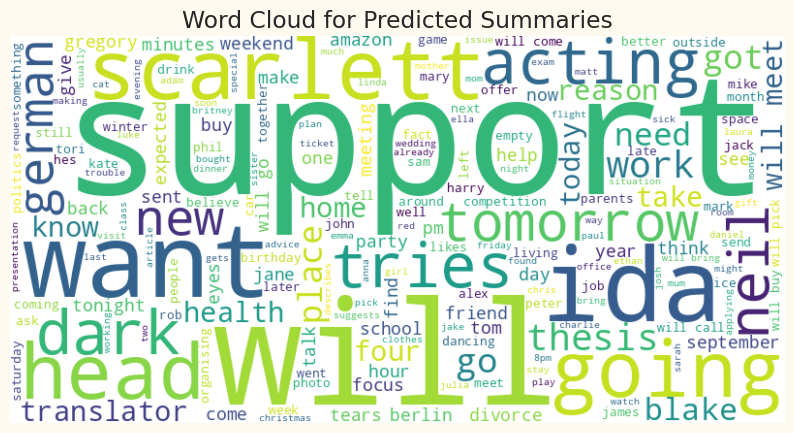

In [87]:
from wordcloud import WordCloud

# Join all the predicted summaries into a single string
predicted_text = ' '.join(predicted_summaries)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(predicted_text)

# Plot the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Predicted Summaries")
plt.show()


## **Comparative Analysis**

In [68]:
from tabulate import tabulate

# Data for the table
headers = ["Metric", "With Attention", "Without Attention"]
data = [
    ["BLEU Score", 0.645, 0.519],
    ["Accuracy", "99.5%", "99.2%"],
    ["Predicted Summary for dialouge 01",
     "hannah needs amazon number but amanda does not have it she needs to contact larry",
     "start hannah needs number but amanda does not have it she needs to attend end"]
]

# Create the table using tabulate
table = tabulate(data, headers, tablefmt="grid")

# Print the table
print(table)


+-----------------------------------+-----------------------------------------------------------------------------------+-------------------------------------------------------------------------------+
| Metric                            | With Attention                                                                    | Without Attention                                                             |
+===================================+===================================================================================+===============================================================================+
| BLEU Score                        | 0.645                                                                             | 0.519                                                                         |
+-----------------------------------+-----------------------------------------------------------------------------------+-----------------------------------------------------------------------

### **BLEU Score Comparison**

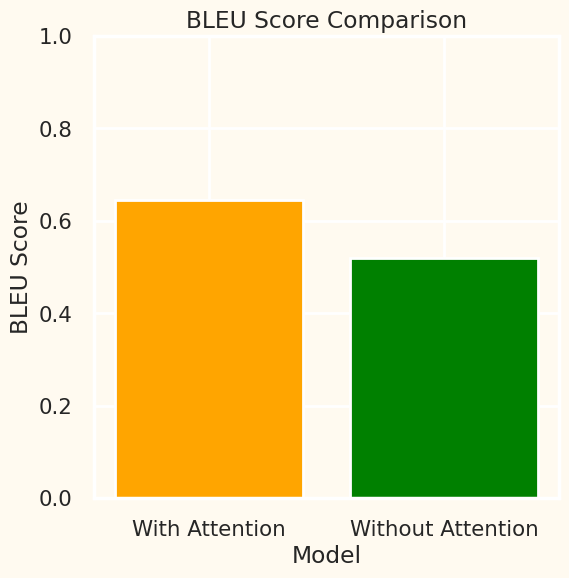

In [106]:
import matplotlib.pyplot as plt

# BLEU scores for the two models
bleu_scores = [0.645, 0.519]
models = ["With Attention", "Without Attention"]

# Create a bar plot
plt.figure(figsize=(6,6))
plt.bar(models, bleu_scores, color=['orange', 'green'])
plt.title('BLEU Score Comparison')
plt.xlabel('Model')
plt.ylabel('BLEU Score')
plt.ylim(0, 1)  # BLEU score range is between 0 and 1
plt.show()


### **Token-Level Confusion Matrix**

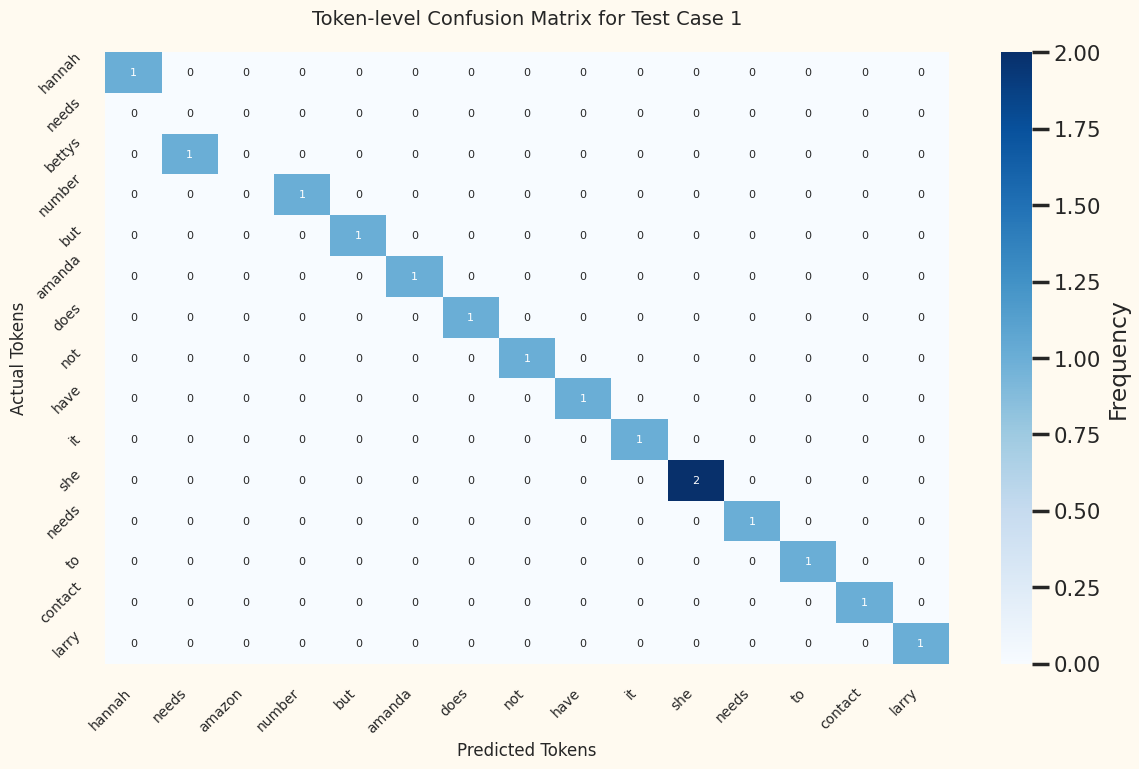

In [111]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

#comparing summaries for the first test case
test_case_idx = 0

# Tokenize the actual and predicted summaries for the test case
predicted_tokens = predicted_summaries[test_case_idx].split()
actual_tokens = actual_summaries[test_case_idx].split()

# Check if the lengths match
if len(predicted_tokens) == len(actual_tokens):
    cm = confusion_matrix(actual_tokens, predicted_tokens)

    # Plot confusion matrix
    plt.figure(figsize=(12, 8))  # Larger figure for better visibility
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=predicted_tokens, yticklabels=actual_tokens,
                annot_kws={"size": 8},  # Smaller font size for annotations
                cbar_kws={'label': 'Frequency'})

    # Title and labels with smaller fonts
    plt.title(f'Token-level Confusion Matrix for Test Case {test_case_idx + 1}', fontsize=14, pad=20)
    plt.xlabel('Predicted Tokens', fontsize=12)
    plt.ylabel('Actual Tokens', fontsize=12)

    # Reduce the size of tick labels
    plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate for better readability
    plt.yticks(rotation=45, ha='right', fontsize=10)

    # Adjust the layout for better spacing
    plt.tight_layout()
    plt.show()
else:
    print(f"Token lengths for test case {test_case_idx + 1} do not match.")


## **Conclusion**


*The comparison between the Encoder-Decoder model with and without attention reveals that the model with attention performs better. It achieves a higher BLEU score (0.645) and accuracy (99.5%) compared to the model without attention (0.519 BLEU, 99.2% accuracy). The summaries generated with attention were more coherent and contextually relevant, while the model without attention produced more generic outputs. These results demonstrate that the attention mechanism significantly improves text summarization by focusing on key input elements, enhancing both the quality and relevance of the generated summaries.*